# COSMOS-Web Catalog Quickstart
Load the catalog, inspect tables, and make core plots.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from matplotlib.colors import LogNorm
from astropy.wcs import WCS
import astropy.units as u

## Load the catalog

In [ ]:
catalog_path = "PATH" # update if needed

In [3]:
with fits.open(catalog_path, memmap=True) as hdul:
    hdul.info()

Filename: D:\Projects\COSMOS\Results\outputs\density\cosmosweb_density_per_slice.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  SLICES        1 BinTableHDU     17   157R x 4C   [J, D, D, D]   
  2  POINTS        1 BinTableHDU     27   1108998R x 9C   [J, K, D, D, D, D, D, D, D]   
  3  OVERDENSITY    1 BinTableHDU     19   164155R x 5C   [K, D, D, E, E]   
  4  DENSITY_000    1 ImageHDU        29   (143, 150)   float32   
  5  DENSITYCONTRAST_000    1 ImageHDU        29   (143, 150)   float32   
  6  DENSITYEXCESS_000    1 ImageHDU        29   (143, 150)   float32   
  7  DENSITYROTATED_000    1 ImageHDU        27   (107, 120)   float32   
  8  DENSITYCONTRASTROTATED_000    1 ImageHDU        27   (107, 120)   float32   
  9  DENSITYEXCESSROTATED_000    1 ImageHDU        27   (107, 120)   float32   
 10  DENSITY_001    1 ImageHDU        29   (143, 150)   float32   
 11  DENSITYCONTRAST_001    1 ImageHDU        2

In [4]:
with fits.open(catalog_path, memmap=True) as hdul:
    slices = Table(hdul["SLICES"].data)
    points = Table(hdul["POINTS"].data)
    overdensity = Table(hdul["OVERDENSITY"].data)
print("SLICES:", np.shape(slices), slices.colnames)
print("POINTS:", np.shape(points), points.colnames)
print("OVERDENSITY:", np.shape(overdensity), overdensity.colnames)

SLICES: (157,) ['slice', 'z', 'b', 'bg_dens']
POINTS: (1108998,) ['slice', 'id', 'RA', 'Dec', 'x', 'y', 'w', 'adaptive_b', 'boundary_corr']
OVERDENSITY: (164155,) ['id', 'RA', 'Dec', 'zPDF', 'density_excess']


## Information about a slice redshift, global smoothing scale, and background density

In [5]:
slice_number = 20
slices[slice_number]

slice,z,b,bg_dens
int32,float64,float64,float64
20,0.723,0.009928581181485699,16789026.589455917


## Information about each object in a slice: location, local smoothing scale, and boundry factor

In [6]:
slice_number = 20
slice_id = int(slices["slice"][slice_number])
sub = points[points["slice"] == slice_id]
print(points.colnames)
print(sub[:10])

['slice', 'id', 'RA', 'Dec', 'x', 'y', 'w', 'adaptive_b', 'boundary_corr']
slice  id          RA         ...      adaptive_b        boundary_corr   
----- ---- ------------------ ... -------------------- ------------------
   20   53 149.80110665614592 ...  0.01492183638032671  0.999999999407092
   20  197 149.75719365738806 ... 0.017546147796956495 1.0007722075957244
   20  357 149.75969448006722 ... 0.017450675773169506 1.0003509535708428
   20  508 149.80351642618427 ... 0.014790218220067606 1.0000000062876138
   20  680 149.84867721499626 ... 0.020314704733021986                1.0
   20  718 149.83759102214384 ... 0.020162230706817327                1.0
   20  819  149.8054403923886 ... 0.014780504726754018 1.0000000081952765
   20  861 149.73543984505488 ... 0.014818846520493936 1.3503562237847915
   20 1156 149.83340847584446 ...  0.01878811160310884 1.0000000063155687
   20 1468 149.74807561060993 ... 0.013855993615437068 1.0322832099414498


## Plotting objects contributing to a slice based on their weight

slice 20 n_points= 10339


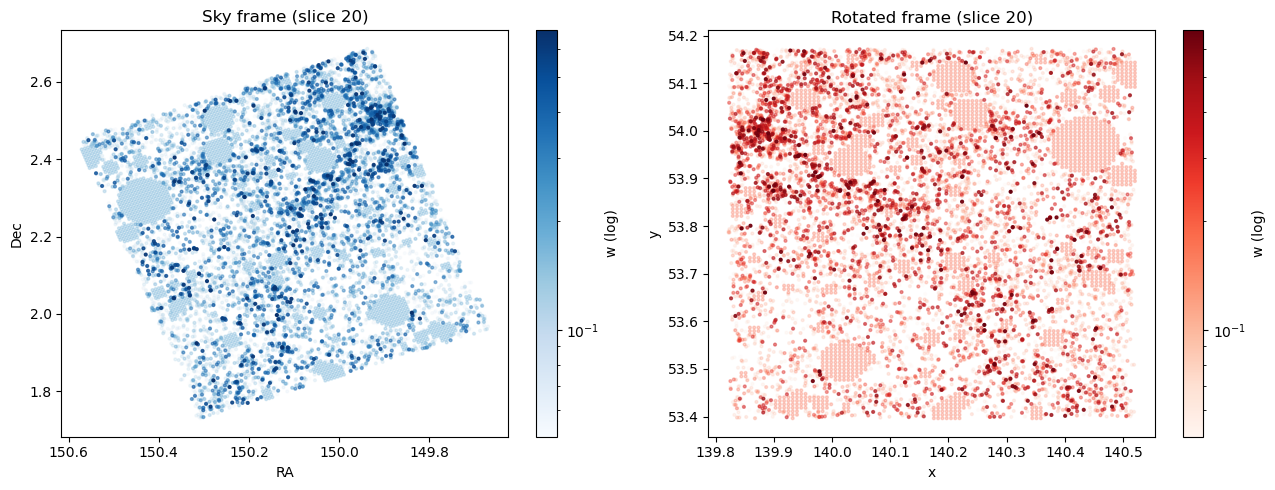

In [7]:
slice_number = 20
slice_id = int(slices["slice"][slice_number])

sub = points[points["slice"] == slice_id]
sub.sort("w")

print("slice", slice_id, "n_points=", len(sub))

w = np.array(sub["w"])
w_pos = np.clip(w, 1e-6, None)  # avoid log(0)

# normalize alpha to [0.05, 1]
alpha = 0.05 + 0.95 * (w_pos - w_pos.min()) / (w_pos.max() - w_pos.min())

norm = LogNorm(vmin=w_pos.min(), vmax=w_pos.max())

fig, ax = plt.subplots(1, 2, figsize=(13, 5))

sc1 = ax[0].scatter(
    sub["RA"], sub["Dec"],
    c=w_pos, s=4,
    cmap="Blues",
    norm=norm,
    alpha=alpha
)
ax[0].set_xlabel("RA")
ax[0].set_ylabel("Dec")
ax[0].set_title(f"Sky frame (slice {slice_id})")
ax[0].invert_xaxis()
plt.colorbar(sc1, ax=ax[0], label="w (log)")

sc2 = ax[1].scatter(
    sub["x"], sub["y"],
    c=w_pos, s=4,
    cmap="Reds",
    norm=norm,
    alpha=alpha
)
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title(f"Rotated frame (slice {slice_id})")
plt.colorbar(sc2, ax=ax[1], label="w (log)")

plt.tight_layout()
plt.show()

## Plotting the overdensity map

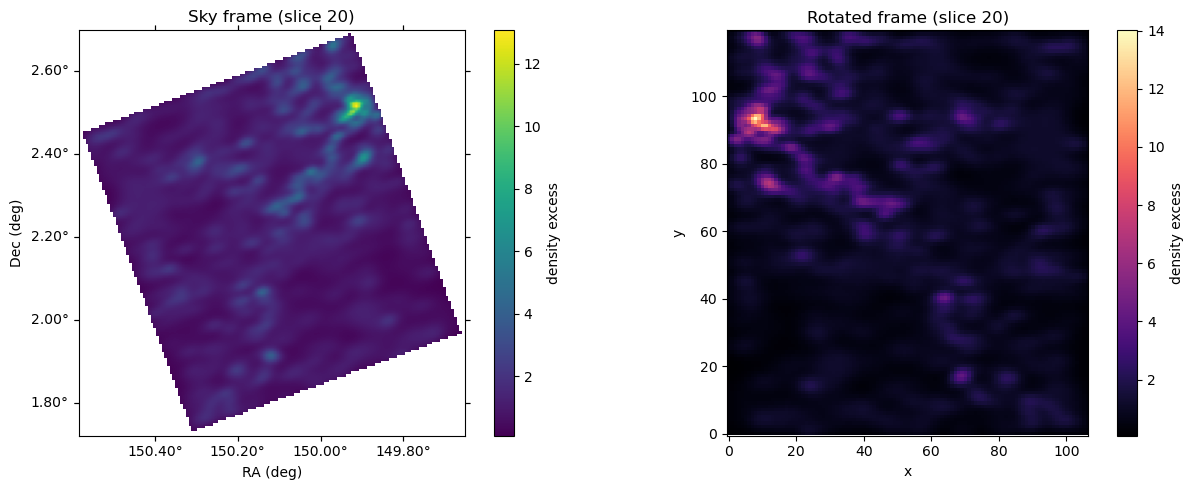

In [8]:
slice_id = 20
tag = f"{slice_id:03d}"

with fits.open(catalog_path, memmap=True) as hdul:
    sky_hdu = hdul[f"DENSITYEXCESS_{tag}"]
    rot_hdu = hdul[f"DENSITYEXCESSROTATED_{tag}"]

    sky = sky_hdu.data.copy()
    rot = rot_hdu.data.copy()
    wcs = WCS(sky_hdu.header)

fig = plt.figure(figsize=(13, 5))
ax0 = fig.add_subplot(1, 2, 1, projection=wcs)
ax1 = fig.add_subplot(1, 2, 2)

im0 = ax0.imshow(sky, origin="lower", cmap="viridis")
ax0.coords[0].set_format_unit(u.deg)
ax0.coords[1].set_format_unit(u.deg)
ax0.coords[0].set_major_formatter("d.dd")
ax0.coords[1].set_major_formatter("d.dd")
ax0.set_xlabel("RA (deg)")
ax0.set_ylabel("Dec (deg)")
ax0.set_title(f"Sky frame (slice {slice_id})")
plt.colorbar(im0, ax=ax0, label="density excess")

im1 = ax1.imshow(rot, origin="lower", cmap="magma")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title(f"Rotated frame (slice {slice_id})")
plt.colorbar(im1, ax=ax1, label="density excess")

plt.tight_layout()
plt.show()

## Accessing the overdensity catalog

In [9]:
overdensity

id,RA,Dec,zPDF,density_excess
int64,float64,float64,float32,float32
3,149.75334444448737,2.1382707712401525,1.6833,0.7778325
4,149.80417938147127,2.1210182600313243,0.9253,1.096246
8,149.83973922187937,2.111194073066386,1.5991,1.5784992
10,149.784907352127,2.131144564653922,1.755,1.186544
12,149.82961488832467,2.1148865258870635,1.3682,2.1920207
17,149.83028311120924,2.114717095836628,1.0194,1.3212099
18,149.8265565893571,2.116031800674511,0.9916,1.3136197
23,149.85064255724456,2.1074207482079013,2.7637,0.9496526
28,149.8162864308862,2.119940942273696,4.2414,1.2478483
